In [1]:
from dataclasses import dataclass, replace
from copy import deepcopy
from typing import Callable, Union
import math

import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from py_vollib.black_scholes.implied_volatility import implied_volatility
implied_volatility_vec = np.vectorize(implied_volatility)

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility
from typing import Union
from scipy import optimize
import cmath
import math
import scipy.integrate as intg
from dataclasses import dataclass
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
implied_volatility_vec = np.vectorize(implied_volatility)

In [3]:
help(implied_volatility)

Help on function implied_volatility in module py_vollib.black_scholes.implied_volatility:

implied_volatility(price, S, K, t, r, flag)
    Calculate the Black-Scholes implied volatility.

    :param price: the Black-Scholes option price
    :type price: float
    :param S: underlying asset price
    :type S: float
    :param K: strike price
    :type K: float
    :param t: time to expiration in years
    :type t: float
    :param r: risk-free interest rate
    :type r: float
    :param flag: 'c' or 'p' for call or put.
    :type flag: str

    >>> S = 100
    >>> K = 100
    >>> sigma = .2
    >>> r = .01
    >>> flag = 'c'
    >>> t = .5

    >>> price = black_scholes(flag, S, K, t, r, sigma)
    >>> iv = implied_volatility(price, S, K, t, r, flag)

    >>> expected_price = 5.87602423383
    >>> expected_iv = 0.2

    >>> abs(expected_price - price) < 0.00001
    True
    >>> abs(expected_iv - iv) < 0.00001
    True



In [4]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
# ХОРОШАЯ РЕАЛИЗАЦИЯ

ticker = yf.Ticker("^SPX")
spot_price =1 #6280.461
today = pd.to_datetime("2025-07-11")
r = 0
q = 0.0

expirations = ticker.options
all_data = []
forwards_by_expiry = {}

for expiration in expirations:
    try:
        chain = ticker.option_chain(expiration)
        calls = chain.calls.copy()
        puts = chain.puts.copy()
    except Exception:
        continue

    T = (pd.to_datetime(expiration) - today).days / 365
    discount_factor = np.exp(-r * T)
    calls_filt = calls[(calls['bid'] > 0) & (calls['ask'] > 0)].copy()
    puts_filt  = puts[(puts['bid'] > 0) & (puts['ask'] > 0)].copy()
    # Мид-цены
    calls_filt['mid'] = (calls_filt['bid'] + calls_filt['ask']) / 2
    puts_filt['mid'] = (puts_filt['bid'] + puts_filt['ask']) / 2
    # Индексация по страйкам
    calls_mid = calls_filt.set_index('strike')['mid']
    puts_mid  = puts_filt.set_index('strike')['mid']
    # Только общие страйки
    common_strikes = calls_mid.index.intersection(puts_mid.index)
    calls_mid = calls_mid.loc[common_strikes]
    puts_mid  = puts_mid.loc[common_strikes]
    if len(common_strikes) == 0:
        forward = spot_price * np.exp((r - q) * T) 
    else:
        price_diff = (calls_mid - puts_mid).abs()
        atmf_strike = price_diff.idxmin()
        forward = (calls_mid[atmf_strike] - puts_mid[atmf_strike]) / discount_factor + atmf_strike

    forwards_by_expiry[expiration] = forward
    for df, is_call in [(calls, True), (puts, False)]:
        df['flag'] = 'c' if is_call else 'p'
        df['is_call'] = is_call
        df['T'] = T
        df['Expiration Date'] = pd.to_datetime(expiration)
        df['S'] = spot_price
        df['r'] = r
        df['q'] = q
        df['mid'] = (df['bid'] + df['ask']) / 2
        df = df[df['mid'] > 0]
        df['forward_atmf'] = forward
        df['discount'] = discount_factor
        all_data.append(df)
df_iv = pd.concat(all_data, ignore_index=True)
def is_otm(row):
    if row['is_call']:
        return row['strike'] >= row['forward_atmf']
    else:
        return row['strike'] <= row['forward_atmf']
df_iv['OTM'] = df_iv.apply(is_otm, axis=1)
df_iv_otm = df_iv[df_iv['OTM']].copy()


C:\Users\User\AppData\Local\Temp\ipykernel_16020\4203780968.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['forward_atmf'] = forward
C:\Users\User\AppData\Local\Temp\ipykernel_16020\4203780968.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['discount'] = discount_factor
C:\Users\User\AppData\Local\Temp\ipykernel_16020\4203780968.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [6]:
df_iv_otm

contractSymbol             lastTradeDate  strike  lastPrice  \
98     SPXW250715C06295000 2025-07-15 10:09:00+00:00  6295.0      14.10   
99     SPXW250715C06300000 2025-07-15 10:10:00+00:00  6300.0      11.80   
100    SPXW250715C06305000 2025-07-15 10:02:53+00:00  6305.0       9.22   
101    SPXW250715C06310000 2025-07-15 10:08:24+00:00  6310.0       7.27   
102    SPXW250715C06315000 2025-07-15 10:10:17+00:00  6315.0       5.80   
...                    ...                       ...     ...        ...   
15676   SPX301220P06600000 2025-06-12 14:24:47+00:00  6600.0     797.06   
15677   SPX301220P06700000 2025-06-20 14:05:41+00:00  6700.0     835.00   
15678   SPX301220P06800000 2025-06-12 14:18:35+00:00  6800.0     854.57   
15679   SPX301220P07000000 2025-07-11 16:29:28+00:00  7000.0     850.00   
15680   SPX301220P07200000 2025-06-12 14:21:49+00:00  7200.0    1017.00   

         bid    ask  change  percentChange  volume  openInterest  ...  \
98      14.2   14.4    7.84      125.23961   443.0             0  ...   
99      11.6   11.9    6.90      140.81633  1618.0             0  ...   
100      9.5    9.7    5.42      142.63158   406.0             0  ...   
101      7.5    7.7    4.37      150.68965  1409.0             0  ...   
102      5.8    6.0    3.62      158.77193   639.0             0  ...   
...      ...    ...     ...            ...     ...           ...  ...   
15676  689.3  767.5    0.00        0.00000     3.0             4  ...   
15677  716.4  777.3    0.00        0.00000     2.0             0  ...   
15678  748.1  827.1    0.00        0.00000     3.0             4  ...   
15679  804.9  868.4    0.00        0.00000     1.0             0  ...   
15680  873.4  954.1    0.00        0.00000     8.0             0  ...   

       is_call         T Expiration Date  S  r    q     mid forward_atmf  \
98        True  0.010959      2025-07-15  1  0  0.0   14.30      6292.85   
99        True  0.010959      2025-07-15  1  0  0.0   11.75      6292.85   
100       True  0.010959      2025-07-15  1  0  0.0    9.60      6292.85   
101       True  0.010959      2025-07-15  1  0  0.0    7.60      6292.85   
102       True  0.010959      2025-07-15  1  0  0.0    5.90      6292.85   
...        ...       ...             ... .. ..  ...     ...          ...   
15676    False  5.446575      2030-12-20  1  0  0.0  728.40      7446.55   
15677    False  5.446575      2030-12-20  1  0  0.0  746.85      7446.55   
15678    False  5.446575      2030-12-20  1  0  0.0  787.60      7446.55   
15679    False  5.446575      2030-12-20  1  0  0.0  836.65      7446.55   
15680    False  5.446575      2030-12-20  1  0  0.0  913.75      7446.55   

       discount   OTM  
98          1.0  True  
99          1.0  True  
100         1.0  True  
101         1.0  True  
102         1.0  True  
...         ...   ...  
15676       1.0  True  
15677       1.0  True  
15678       1.0  True  
15679       1.0  True  
15680       1.0  True  

[9539 rows x 25 columns]

In [7]:
df_iv_clean = df_iv_otm[(df_iv_otm['T'] >= 0.5) & (df_iv_otm['T'] <= 1.5)]


In [8]:
df_iv_clean

contractSymbol             lastTradeDate  strike  lastPrice    bid  \
12305  SPX260116C06425000 2025-07-15 08:58:41+00:00  6425.0     258.22  259.9   
12306  SPX260116C06450000 2025-07-15 08:58:41+00:00  6450.0     243.45  245.4   
12307  SPX260116C06475000 2025-07-11 19:07:53+00:00  6475.0     213.71  230.8   
12308  SPX260116C06500000 2025-07-14 19:04:39+00:00  6500.0     208.49  217.2   
12309  SPX260116C06525000 2025-07-14 15:16:02+00:00  6525.0     189.30  203.7   
...                   ...                       ...     ...        ...    ...   
15060  SPX261218P06475000 2025-06-26 14:26:28+00:00  6475.0     510.10  439.0   
15061  SPX261218P06500000 2025-07-14 18:15:31+00:00  6500.0     459.58  447.8   
15062  SPX261218P06525000 2025-03-10 14:15:24+00:00  6525.0     761.90  991.7   
15063  SPX261218P06550000 2025-07-09 15:46:01+00:00  6550.0     486.60  465.4   
15064  SPX261218P06575000 2025-07-08 17:01:39+00:00  6575.0     504.25  474.3   

          ask     change  percentChange  volume  openInterest  ...  is_call  \
12305   262.0  10.619995       4.289174     1.0             0  ...     True   
12306   247.0   9.449997       4.038460     1.0             0  ...     True   
12307   233.0   0.000000       0.000000     7.0             0  ...     True   
12308   218.9   0.000000       0.000000     8.0             0  ...     True   
12309   205.9   0.000000       0.000000     1.0             0  ...     True   
...       ...        ...            ...     ...           ...  ...      ...   
15060   443.7   0.000000       0.000000     2.0             0  ...    False   
15061   451.7   0.000000       0.000000   202.0             0  ...    False   
15062  1029.2   0.000000       0.000000     NaN             1  ...    False   
15063   469.3   0.000000       0.000000   250.0             0  ...    False   
15064   479.0   0.000000       0.000000     2.0             0  ...    False   

              T Expiration Date  S  r    q      mid forward_atmf  discount  \
12305  0.517808      2026-01-16  1  0  0.0   260.95       6411.3       1.0   
12306  0.517808      2026-01-16  1  0  0.0   246.20       6411.3       1.0   
12307  0.517808      2026-01-16  1  0  0.0   231.90       6411.3       1.0   
12308  0.517808      2026-01-16  1  0  0.0   218.05       6411.3       1.0   
12309  0.517808      2026-01-16  1  0  0.0   204.80       6411.3       1.0   
...         ...             ... .. ..  ...      ...          ...       ...   
15060  1.438356      2026-12-18  1  0  0.0   441.35       6592.6       1.0   
15061  1.438356      2026-12-18  1  0  0.0   449.75       6592.6       1.0   
15062  1.438356      2026-12-18  1  0  0.0  1010.45       6592.6       1.0   
15063  1.438356      2026-12-18  1  0  0.0   467.35       6592.6       1.0   
15064  1.438356      2026-12-18  1  0  0.0   476.65       6592.6       1.0   

        OTM  
12305  True  
12306  True  
12307  True  
12308  True  
12309  True  
...     ...  
15060  True  
15061  True  
15062  True  
15063  True  
15064  True  

[1791 rows x 25 columns]

In [9]:
strikes_per_maturity = df_iv_clean.groupby('Expiration Date')['strike'].apply(set)
common_strikes = set.intersection(*strikes_per_maturity)
print("Общие страйки для всех maturity:", common_strikes)

Общие страйки для всех maturity: {4100.0, 6150.0, 3600.0, 5650.0, 3100.0, 5150.0, 6175.0, 7200.0, 2600.0, 4650.0, 5675.0, 6700.0, 5175.0, 6200.0, 5700.0, 5200.0, 6225.0, 4700.0, 5725.0, 6750.0, 4200.0, 6250.0, 3700.0, 3200.0, 5250.0, 6275.0, 7300.0, 4750.0, 5775.0, 6800.0, 4250.0, 5275.0, 6300.0, 5800.0, 5300.0, 6325.0, 4800.0, 5825.0, 6850.0, 4300.0, 6350.0, 3800.0, 5850.0, 3300.0, 6375.0, 7400.0, 2800.0, 4850.0, 5875.0, 6900.0, 4350.0, 6400.0, 5900.0, 5400.0, 6425.0, 4900.0, 5925.0, 4400.0, 5425.0, 6450.0, 3900.0, 5950.0, 3400.0, 4950.0, 5975.0, 7000.0, 4450.0, 5475.0, 6500.0, 6000.0, 5500.0, 5000.0, 6025.0, 4500.0, 5525.0, 4000.0, 6050.0, 3500.0, 5550.0, 7600.0, 3000.0, 6075.0, 7100.0, 4550.0, 5575.0, 6600.0, 5075.0, 6100.0, 5600.0, 5100.0, 6125.0, 4600.0, 5625.0, 6650.0}


In [10]:
filtered_df = df_iv_clean[df_iv_clean['strike'].isin(common_strikes)]
print("Отфильтрованный датасет:\n", filtered_df)

Отфильтрованный датасет:
            contractSymbol             lastTradeDate  strike  lastPrice    bid  \
12305  SPX260116C06425000 2025-07-15 08:58:41+00:00  6425.0     258.22  259.9   
12306  SPX260116C06450000 2025-07-15 08:58:41+00:00  6450.0     243.45  245.4   
12308  SPX260116C06500000 2025-07-14 19:04:39+00:00  6500.0     208.49  217.2   
12312  SPX260116C06600000 2025-07-14 19:00:40+00:00  6600.0     159.70  167.0   
12314  SPX260116C06650000 2025-07-11 14:30:10+00:00  6650.0     135.10  144.9   
...                   ...                       ...     ...        ...    ...   
15056  SPX261218P06375000 2025-06-17 19:35:46+00:00  6375.0     531.90  406.7   
15057  SPX261218P06400000 2025-07-14 15:08:30+00:00  6400.0     430.57  414.6   
15058  SPX261218P06425000 2025-06-26 14:34:05+00:00  6425.0     488.70  422.6   
15059  SPX261218P06450000 2025-06-23 15:57:31+00:00  6450.0     569.54  430.9   
15061  SPX261218P06500000 2025-07-14 18:15:31+00:00  6500.0     459.58  447.8   

 

In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, 12305 to 15061
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     1034 non-null   object             
 1   lastTradeDate      1034 non-null   datetime64[ns, UTC]
 2   strike             1034 non-null   float64            
 3   lastPrice          1034 non-null   float64            
 4   bid                1034 non-null   float64            
 5   ask                1034 non-null   float64            
 6   change             1034 non-null   float64            
 7   percentChange      1034 non-null   float64            
 8   volume             1005 non-null   float64            
 9   openInterest       1034 non-null   int64              
 10  impliedVolatility  1034 non-null   float64            
 11  inTheMoney         1034 non-null   bool               
 12  contractSize       1034 non-null   object       

In [12]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]
@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion 
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions


def heston_cf(s, v, kappa, theta, sigma, rho, u, t):
    """Characteristic function of the log-price in the Heston model."""
    d = cmath.sqrt((rho * sigma * u * 1j - kappa) ** 2 + sigma ** 2 * (u * 1j + u ** 2))
    g = ((rho * sigma * u * 1j - kappa + d) / (rho * sigma * u * 1j - kappa - d))
    C = (kappa * theta / sigma ** 2 * (
        t * (kappa - rho * sigma * u * 1j - d) -
        2 * cmath.log((1 - g * cmath.exp(-d * t)) / (1 - g))))
    D = ((kappa - rho * sigma * u * 1j - d) / sigma ** 2 *
         ((1 - cmath.exp(-d * t)) / (1 - g * cmath.exp(-d * t))))
    return cmath.exp(C + D * v + u * math.log(s) * 1j)

def heston_cf_copy(s, v, kappa, theta, sigma, rho, u, t):
    """Characteristic function of the log-price in the Heston model."""
    d = cmath.sqrt((rho * sigma * u * 1j - kappa) ** 2 + sigma ** 2 * (u * 1j + u ** 2))
    g = ((rho * sigma * u * 1j - kappa + d) / (rho * sigma * u * 1j - kappa - d))
    C = (kappa * theta / sigma ** 2 * (
        t * (kappa - rho * sigma * u * 1j - d) -
        2 * cmath.log((1 - g * cmath.exp(-d * t)) / (1 - g))))
    D = ((kappa - rho * sigma * u * 1j - d) / sigma ** 2 *
         ((1 - cmath.exp(-d * t)) / (1 - g * cmath.exp(-d * t))))
    return cmath.exp(C + D * v + u * math.log(s) * 1j), d, g, C, D, math.log(s)

def heston_integrand(u, t, k,  s, r, v, kappa, theta, sigma, rho):
    """Integrand in Heston's formula."""
    return (cmath.exp(-1j * u * math.log(k)) / (1j * u) *
            (cmath.exp(r * t) * heston_cf(s, v, kappa, theta, sigma, rho, u - 1j, t) -
             k * heston_cf(s, v, kappa, theta, sigma, rho, u, t))).real

def heston_scalar(t: float, k: float, s: float, r: float, is_call: bool, heston_params: HestonParams) -> float:
    """Computes the price of a call option by Heston's semi-closed formula.

    This is an auxiliary function which works with scalar expiration time
    and strike. It is called by `call_price`, which allows vectorization.
    """
    call_price = (0.5 * (s - math.exp(- r * t) * k) +
                  1 / math.pi * math.exp(- r * t) *
                  intg.quad(
                    heston_integrand,
                    0, math.inf,
                    args=(t, k, s, r, heston_params.v, heston_params.kappa, heston_params.theta,
                    heston_params.sigma, heston_params.rho))[0])
    if is_call:
        return call_price

    return call_price + k * np.exp(- r * t) - s

def heston(t: Union[float, np.ndarray],
           k: Union[float, np.ndarray],
           s: float, r: float,
           is_call: Union[bool, np.ndarray],
           heston_params: HestonParams) -> Union[float, np.ndarray]:
    """Computes the price of a call option by Heston's semi-closed formula.

        Args:
            t: Expiration time (float or ndarray).
            k: Strike (float or ndarray).
            s: Asset price S_0.
            r: Interest rate r.

        Returns:
            If `t` and `k` are scalars, returns the price of a call option as a
            scalar value. If `t` and/or `k` are arrays, applies NumPy
            broadcasting rules and returns an array of prices.
    """
    b = np.broadcast(t, k)
    if b.nd:  # Vector arguments were supplied
        return np.fromiter(
            (heston_scalar(t_, k_, s, r, is_call, heston_params) for (t_, k_) in b),
            count=b.size, dtype=float).reshape(b.shape)
    else:
        return heston(t, k, s, r, is_call, heston_params)


class BaseHestonSimulState:
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        raise NotImplementedError

    @property
    def stock_price(self) -> Floats:
        raise NotImplementedError

    @property
    def time(self) -> Floats:
        raise NotImplementedError
        
    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        raise NotImplementedError

In [13]:
def simulate_heston(
    params: HestonParams,
    initial_simul_state: BaseHestonSimulState,
    time_stop: float = 1.0,
    n_time_steps: int = 100,
    random_seed: int = 0x11A_3AB0D,
    ret_intermediate_states: bool = False,
):
    random = np.random.default_rng(random_seed)
    dt = (time_stop - initial_simul_state.time) / n_time_steps
    hs = initial_simul_state
    
    if ret_intermediate_states:
        states = [deepcopy(hs)]
        
    stock_price = np.empty((*np.shape(initial_simul_state.stock_price), n_time_steps + 1))
    stock_price[:, 0] = initial_simul_state.stock_price
    
    for i in trange(n_time_steps):
        hs.advance(dt, random)
        stock_price[:, i + 1] = hs.stock_price
        
        if ret_intermediate_states:
            states.append(deepcopy(hs))
    
    if ret_intermediate_states:
        return stock_price, states
    
    return stock_price

In [14]:
r

0

In [15]:
N_PATHS = 100000
N_STEPS = 1500
T = 1.5

params = HestonParams(v=0.1, kappa=3, theta=0.3, sigma=0.5, rho=-0.2)
ms = MarketState(stock_price=spot_price, interest_rate=r, time=0)

In [16]:
class AndersenLikeSimulState(BaseHestonSimulState):
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        self._log_stock_price = np.full(shape, np.log(ms.stock_price))
        self._variance = np.full(shape, params.v)
        self._interest_rate = ms.interest_rate
        self._p = params
        self._t = ms.time
    
    @property
    def log_stock_price(self):
        return self._log_stock_price
    
    @property
    def time(self):
        return self._t
        
    @property
    def stock_price(self):
        return np.exp(self._log_stock_price)
    
    @property
    def variance(self):
        return self._variance
    
    @staticmethod
    def _sample_noncentral_chi2(
        random: np.random.Generator,
        df: Floats,
        lam: Floats,
    ):
        pois = random.poisson(lam / 2)
        return random.chisquare(df + 2 * pois)

    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        k0 = (
            -self._p.rho * self._p.kappa * self._p.theta
            * dt / self._p.sigma
        )
        k2 = self._p.rho / self._p.sigma
        k1 = (self._p.kappa * k2 - 0.5) * dt - k2
        k3 = (1 - self._p.rho ** 2) * dt

        c = 4 * self._p.kappa / self._p.sigma ** 2
        decay = np.exp(-self._p.kappa * dt)

        new_v = (1 - decay) / c * self._sample_noncentral_chi2(
            random,
            df=c * self._p.theta,
            lam=self._variance * c * decay / (1 - decay),
        )
        new_log_s = (
            self._log_stock_price + k0 + k1 * self._variance + k2 * new_v
            + np.sqrt(k3 * self._variance) * random.normal(size=np.shape(self._log_stock_price))
        )
        
        self._log_stock_price = new_log_s
        self._variance = new_v
        self._t += dt

In [17]:
hs = AndersenLikeSimulState(params, ms, N_PATHS)
paths, states = simulate_heston(
    params,
    # replace(params, theta=20.0),
    hs,
    time_stop=T,
    n_time_steps=N_STEPS,
    ret_intermediate_states=True,
)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [18]:
paths.shape

(100000, 1501)

In [19]:
paths

array([[1.        , 0.9831936 , 1.01456551, ..., 0.41523819, 0.42637968,
        0.42321223],
       [1.        , 1.00171423, 0.99833022, ..., 0.80071857, 0.8347805 ,
        0.84138008],
       [1.        , 1.00450382, 0.99964752, ..., 0.47769727, 0.47949021,
        0.47699481],
       ...,
       [1.        , 0.99866886, 1.01366501, ..., 0.90024971, 0.90088348,
        0.90063899],
       [1.        , 1.00030252, 0.9804456 , ..., 1.97992676, 2.00857725,
        2.00976177],
       [1.        , 1.00834108, 1.0177944 , ..., 1.17756823, 1.19141017,
        1.19855561]])

In [20]:
df_filtered=filtered_df[['strike','Expiration Date','mid','is_call','T']]

In [21]:
df_filtered['mid'].mean()

146.04970986460347

In [22]:
import pandas as pd
import numpy as np

def create_option_grid(spot_price: float, 
                      strike_step: float = 0.05, 
                      time_step: float = 0.1) -> pd.DataFrame:
    """
    Create a grid of option strikes and expiration times with OTM option type.
    
    Parameters:
    -----------
    spot_price : float
        Current spot price of the underlying asset
    strike_step : float, optional
        Step size between strikes as a fraction of spot_price (default: 0.05)
    time_step : float, optional
        Step size between expiration times in years (default: 0.1)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['K', 'T', 'option_type']
    """
    min_strike = 0.8 * spot_price
    max_strike = 1.2 * spot_price
    strikes = np.arange(min_strike, max_strike + strike_step * spot_price, 
                       strike_step * spot_price)
    min_time = 0.5
    max_time = 1.5
    times = np.arange(min_time, max_time + time_step, time_step)
    grid = pd.DataFrame([(K, T) for K in strikes for T in times], 
                       columns=['K', 'T'])
    grid['is_call'] = grid['K'].apply(
        lambda K: True if K > spot_price else False
    )
    grid.loc[grid['K'] == spot_price, 'is_call'] = True
    
    return grid

In [23]:
spot = spot_price  
option_grid = create_option_grid(spot)
print(option_grid.head(10))

     K    T  is_call
0  0.8  0.5    False
1  0.8  0.6    False
2  0.8  0.7    False
3  0.8  0.8    False
4  0.8  0.9    False
5  0.8  1.0    False
6  0.8  1.1    False
7  0.8  1.2    False
8  0.8  1.3    False
9  0.8  1.4    False


In [24]:
df_filtered=option_grid

In [25]:
df_filtered['r']=r
df_filtered['spot']=spot

In [26]:
df_filtered.tail()

K    T  is_call  r  spot
94  1.2  1.1     True  0     1
95  1.2  1.2     True  0     1
96  1.2  1.3     True  0     1
97  1.2  1.4     True  0     1
98  1.2  1.5     True  0     1

In [27]:
mid = []
for dt in df_filtered['T'].unique():
    index = int(dt*1000)
    for strike in df_filtered['K'].unique():
        condition = (df_filtered['T'] == dt) & (df_filtered['K'] == strike)
        sgn = df_filtered.loc[condition]['is_call'].values[0]
        price = heston(t=np.array([dt]), k=strike, s=spot, r=r, is_call=sgn, heston_params=params)
        mid.append(price[0])

In [28]:
df_filtered['mid']=mid

In [29]:
df_filtered.head()

K    T  is_call  r  spot       mid
0  0.8  0.5    False  0     1  0.039654
1  0.8  0.6    False  0     1  0.055345
2  0.8  0.7    False  0     1  0.074463
3  0.8  0.8    False  0     1  0.097046
4  0.8  0.9    False  0     1  0.123020

In [30]:
df_filtered.tail()

K    T  is_call  r  spot       mid
94  1.2  1.1     True  0     1  0.240431
95  1.2  1.2     True  0     1  0.221831
96  1.2  1.3     True  0     1  0.204694
97  1.2  1.4     True  0     1  0.188914
98  1.2  1.5     True  0     1  0.174392

In [31]:
from scipy.optimize import minimize

In [32]:
df_filtered.head(10)

K    T  is_call  r  spot       mid
0  0.8  0.5    False  0     1  0.039654
1  0.8  0.6    False  0     1  0.055345
2  0.8  0.7    False  0     1  0.074463
3  0.8  0.8    False  0     1  0.097046
4  0.8  0.9    False  0     1  0.123020
5  0.8  1.0    False  0     1  0.102220
6  0.8  1.1    False  0     1  0.084414
7  0.8  1.2    False  0     1  0.069327
8  0.8  1.3    False  0     1  0.056661
9  0.8  1.4    False  0     1  0.050502

In [33]:
params

HestonParams(v=0.1, kappa=3, theta=0.3, sigma=0.5, rho=-0.2)

In [34]:
heston(t=np.array([1.5]), k=1.2, s=1, r=0, is_call=True, heston_params=params)

array([0.17439184])

In [35]:
strikes_per_maturity = df_iv_clean.groupby('T')['strike'].apply(set)
common_strikes = set.intersection(*strikes_per_maturity)

In [36]:
filtered_df = df_iv_clean[df_iv_clean['strike'].isin(common_strikes)]

In [37]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, 12305 to 15061
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     1034 non-null   object             
 1   lastTradeDate      1034 non-null   datetime64[ns, UTC]
 2   strike             1034 non-null   float64            
 3   lastPrice          1034 non-null   float64            
 4   bid                1034 non-null   float64            
 5   ask                1034 non-null   float64            
 6   change             1034 non-null   float64            
 7   percentChange      1034 non-null   float64            
 8   volume             1005 non-null   float64            
 9   openInterest       1034 non-null   int64              
 10  impliedVolatility  1034 non-null   float64            
 11  inTheMoney         1034 non-null   bool               
 12  contractSize       1034 non-null   object       

In [38]:
filtered_df['Expiration Date'].unique()

<DatetimeArray>
['2026-01-16 00:00:00', '2026-02-20 00:00:00', '2026-03-20 00:00:00',
 '2026-03-31 00:00:00', '2026-04-17 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-06-30 00:00:00', '2026-07-17 00:00:00',
 '2026-09-18 00:00:00', '2026-12-18 00:00:00']
Length: 11, dtype: datetime64[ns]

In [39]:
df_filtered.describe()

K          T     r  spot        mid
count  99.000000  99.000000  99.0  99.0  99.000000
mean    1.000000   1.000000   0.0   1.0   0.138263
std     0.129756   0.317837   0.0   0.0   0.045867
min     0.800000   0.500000   0.0   1.0   0.039654
25%     0.900000   0.700000   0.0   1.0   0.101839
50%     1.000000   1.000000   0.0   1.0   0.138140
75%     1.100000   1.300000   0.0   1.0   0.173067
max     1.200000   1.500000   0.0   1.0   0.240431

In [40]:
def iv_black_scholes(price: Union[float, np.ndarray], S: float,
                     K: Union[float, np.ndarray], t: Union[float, np.ndarray],
                     r: float, is_call: bool):
    """
    Returns implied volatility from given options' prices.
    """
    return implied_volatility_vec(price=price, S=S, K=K, t=t, r=r, flag='c' if is_call else 'p')


In [41]:
import pandas as pd
import numpy as np
from typing import Union

def calculate_iv_from_dataframe(df: pd.DataFrame, 
                               price_col: str, 
                               S_col: str, 
                               K_col: str, 
                               t_col: str, 
                               r_col: str, 
                               is_call_col: str) -> pd.Series:
    """
    Calculate implied volatility for each row in a DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing options data
    price_col : str
        Column name for option prices
    S_col : str
        Column name for underlying asset prices
    K_col : str
        Column name for strike prices
    t_col : str
        Column name for time to expiration (in years)
    r_col : str
        Column name for risk-free rates
    is_call_col : str
        Column name indicating whether option is call (True) or put (False)
        
    Returns:
    --------
    pd.Series
        Series of implied volatilities
    """
    iv_series = df.apply(lambda row: iv_black_scholes(
        price=row[price_col],
        S=row[S_col],
        K=row[K_col],
        t=row[t_col],
        r=row[r_col],
        is_call=row[is_call_col]
    ), axis=1)
    
    return iv_series

In [42]:
df_filtered['spot']=spot_price

In [43]:
df_filtered['r']=r

In [44]:
df_filtered['iv']=calculate_iv_from_dataframe(df_filtered, 'mid','spot','K','T','r','is_call')

In [45]:
intrinsic = abs(np.maximum((-1)**(df_filtered['is_call']+1)*(spot_price - df_filtered['K']), 0.0))
df_filtered['int']=intrinsic
df_filtered[(df_filtered['mid']-df_filtered['int']<0)]

Empty DataFrame
Columns: [K, T, is_call, r, spot, mid, iv, int]
Index: []

In [46]:
df_filtered['K'].nunique()

9

In [47]:
df_filtered.head()

K    T  is_call  r  spot       mid                  iv  int
0  0.8  0.5    False  0     1  0.039654  0.4467425695348443  0.0
1  0.8  0.6    False  0     1  0.055345   0.479055395583246  0.0
2  0.8  0.7    False  0     1  0.074463   0.519771463985954  0.0
3  0.8  0.8    False  0     1  0.097046  0.5676375611770004  0.0
4  0.8  0.9    False  0     1  0.123020  0.6217574673443651  0.0

In [48]:
def paying_function(par):
    #версия со spot_price=1, r=0 для теста
    #try:
        #print('z')
        params = HestonParams(v=par[0], kappa=par[1], theta=par[2], sigma=par[3], rho=par[4])
        spot_price = df_filtered.iloc[0,4]
        r = df_filtered.iloc[0,3]
        #N_PATHS = 10000
        #T = 1.5
        #N_STEPS = 300
        ms = MarketState(stock_price=spot_price, interest_rate=r, time=0)
        hs = AndersenLikeSimulState(params, ms, N_PATHS)
        M = df_filtered.shape[0]
        
        #paths, states = simulate_heston(
         #   params,
          #  hs,
           # time_stop=T,
            #n_time_steps=N_STEPS,
           # ret_intermediate_states=True,
        #)

        func = 0.0 
        for dt in df_filtered['T'].unique():
            #index = int(dt*200)
            iv_list=[]
            for strike in df_filtered['K'].unique():
                condition = (df_filtered['T'] == dt) & (df_filtered['K'] == strike)
                if df_filtered.loc[condition].empty:
                    continue
                    
                sgn = df_filtered.loc[condition, 'is_call'].values[0]
                call_put_sign = (-1)**(sgn+1)
                iv_tabl=df_filtered.loc[condition,'iv'].values[0]
                price = heston(t=np.array([dt]), k=strike, s=spot_price, r=r, is_call=sgn, heston_params=params)#np.exp(-r*dt)*np.maximum(call_put_sign * (paths[:, index] - strike), 0)
                mid = df_filtered.loc[condition, 'mid'].values[0]
                iv=iv_black_scholes(price.mean(),spot_price,strike,dt,r, sgn)
                func =func+ 20*((iv - iv_tabl)**2)/(spot_price**2)
                iv_list.append(iv)
            skew=(iv_list[5]-iv_list[3])/0.1
            conv=(iv_list[5]-2*iv_list[4]+iv_list[3])/((0.1)**2)
            tmp_df=df_filtered[(df_filtered['T'] == dt)]
            #print(conv)ww
            skew_true=(tmp_df.iloc[5,6]-tmp_df.iloc[3,6])/0.1
            conv_true=(tmp_df.iloc[5,6]-2*tmp_df.iloc[4,6]+tmp_df.iloc[3,6])/((0.1)**2)
            func=func+(skew-skew_true)**2+(conv-conv_true)**2
        if M == 0:
            return float('inf') 
        #print(func/ M)
        return func / M
    
    #except Exception as e:
     #   print(f"Ошибка в paying_function: {str(e)}")
      #  return float('inf')  # Возвращаем "бесконечность" при ошибках

In [49]:
from scipy.optimize import differential_evolution

In [50]:
bounds = [(0,0.5), (0, 5), (0, 0.5), (0, 1), (-1, 0)]

In [51]:
x0 = np.array([0.3, 3, 0.3, 0.5, -0.7])
#simp=matson_simplex(x0, h=0.5)
result =minimize(
    paying_function,      
    x0=x0,
    method="Nelder-Mead", 
    options={
        'maxiter': 15, 
        'xatol': 1e-2,    
        'fatol': 1e-2,    
    }
)

print("Результат оптимизации:")
print("x =", result.x)          
print("f(x) =", result.fun)    
print("Итераций:", result.nit)  
print("Вызовов функции:", result.nfev)  

Результат оптимизации:
x = [ 0.3390157   2.99081754  0.20593942  0.60390366 -0.6714216 ]
f(x) = 49.253785686505005
Итераций: 15
Вызовов функции: 26


In [52]:
print(x0, "\n",result.x, "\n",params)

[ 0.3  3.   0.3  0.5 -0.7] 
 [ 0.3390157   2.99081754  0.20593942  0.60390366 -0.6714216 ] 
 HestonParams(v=0.1, kappa=3, theta=0.3, sigma=0.5, rho=-0.2)


In [53]:
N_PATHS = 100000
N_STEPS = 1500
T = 1.5

params = HestonParams(v=result.x[0], kappa=result.x[1], theta=result.x[2], sigma=result.x[3], rho=result.x[4])
ms = MarketState(stock_price=spot_price, interest_rate=r, time=0)

In [54]:
hs = AndersenLikeSimulState(params, ms, N_PATHS)
paths, states = simulate_heston(
    params,
    # replace(params, theta=20.0),
    hs,
    time_stop=T,
    n_time_steps=N_STEPS,
    ret_intermediate_states=True,
)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [55]:
params

HestonParams(v=0.3390157016260614, kappa=2.9908175385722853, theta=0.20593941845606412, sigma=0.6039036575252485, rho=-0.6714216012521506)

In [56]:
spot = spot_price  
option_grid = create_option_grid(spot)
print(option_grid.head(10))

     K    T  is_call
0  0.8  0.5    False
1  0.8  0.6    False
2  0.8  0.7    False
3  0.8  0.8    False
4  0.8  0.9    False
5  0.8  1.0    False
6  0.8  1.1    False
7  0.8  1.2    False
8  0.8  1.3    False
9  0.8  1.4    False


In [57]:
mid = []
for dt in option_grid['T'].unique():
    index = int(dt*365)-1
    for strike in option_grid['K'].unique():
        condition = (option_grid['T'] == dt) & (option_grid['K'] == strike)
        sgn = option_grid.loc[condition]['is_call'].values[0]
        price = heston(t=np.array([dt]), k=strike, s=spot, r=r, is_call=sgn, heston_params=params)
        mid.append(price.mean())  

In [58]:
option_grid['mid']=mid

In [59]:
option_grid['spot']=spot_price

In [60]:
option_grid['r']=r

In [61]:
option_grid['iv']=calculate_iv_from_dataframe(option_grid, 'mid','spot','K','T','r','is_call')

In [62]:
option_grid.head()

K    T  is_call       mid  spot  r                  iv
0  0.8  0.5    False  0.058139     1  0  0.5382215980973633
1  0.8  0.6    False  0.075143     1  0  0.5642885559082484
2  0.8  0.7    False  0.094930     1  0  0.5987619976370966
3  0.8  0.8    False  0.117530     1  0  0.6401599962031639
4  0.8  0.9    False  0.142920     1  0   0.687576452439334

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

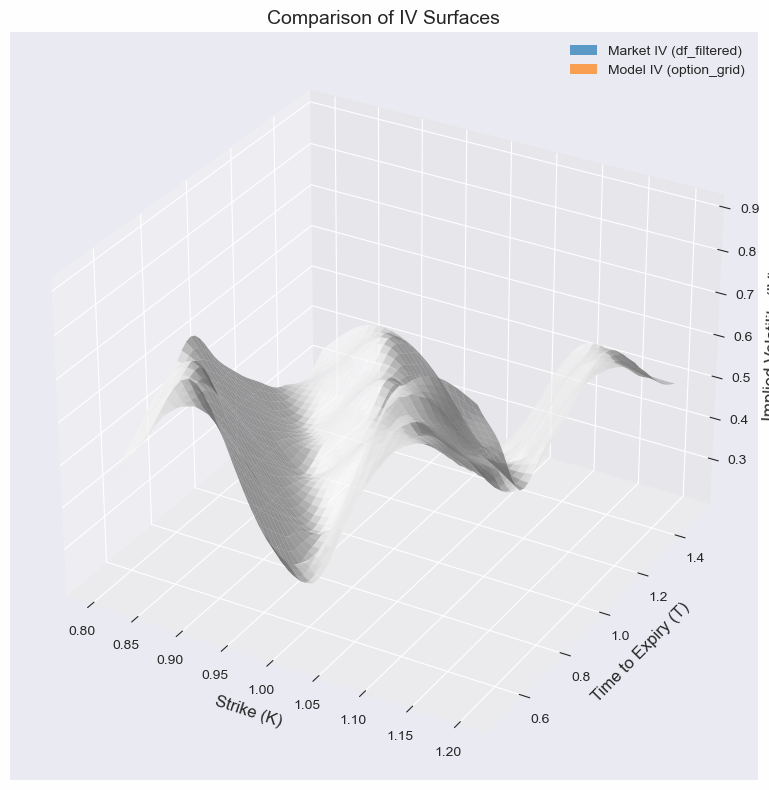

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

K_grid = np.linspace(min(df_filtered['K'].min(), option_grid['K'].min()), 
                     max(df_filtered['K'].max(), option_grid['K'].max()), 50)
T_grid = np.linspace(min(df_filtered['T'].min(), option_grid['T'].min()), 
                     max(df_filtered['T'].max(), option_grid['T'].max()), 50)
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)
iv_mesh_true = griddata(
    (df_filtered['K'], df_filtered['T']), df_filtered['iv'],
    (K_mesh, T_mesh), method='cubic'
)
iv_mesh_calc = griddata(
    (option_grid['K'], option_grid['T']), option_grid['iv'],
    (K_mesh, T_mesh), method='cubic'
)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_true = ax.plot_surface(
    K_mesh, T_mesh, iv_mesh_true, 
    color='white', alpha=0.7, label='Market IV'
)
ax.set_xlabel('Strike (K)', fontsize=12)
ax.set_ylabel('Time to Expiry (T)', fontsize=12)
ax.set_zlabel('Implied Volatility (IV)', fontsize=12)
ax.set_title('Comparison of IV Surfaces', fontsize=14)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='tab:blue', alpha=0.7, label='Market IV (df_filtered)'),
    Patch(facecolor='tab:orange', alpha=0.7, label='Model IV (option_grid)')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

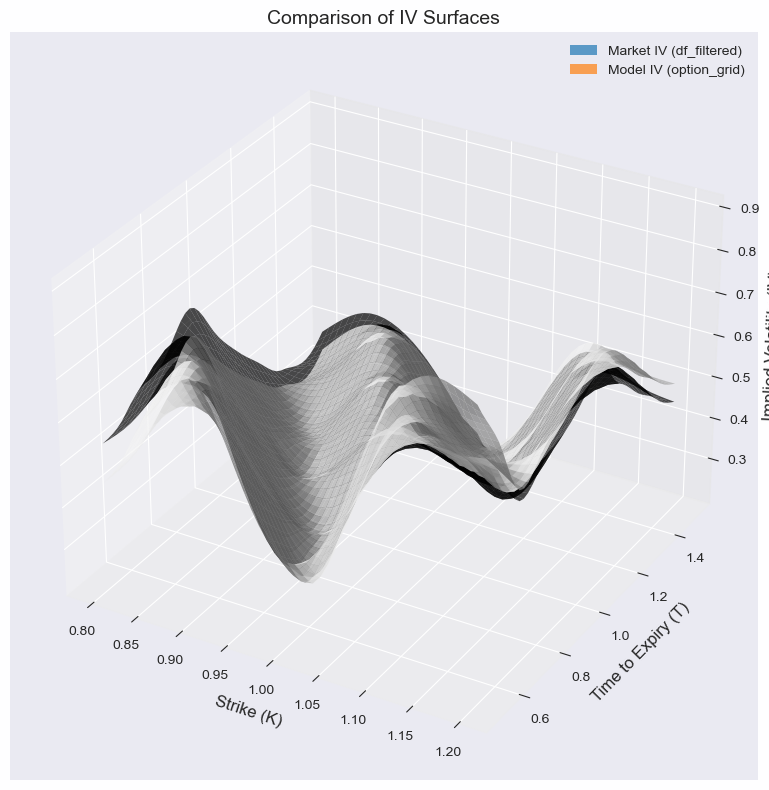

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
K_grid = np.linspace(min(df_filtered['K'].min(), option_grid['K'].min()), 
                     max(df_filtered['K'].max(), option_grid['K'].max()), 50)
T_grid = np.linspace(min(df_filtered['T'].min(), option_grid['T'].min()), 
                     max(df_filtered['T'].max(), option_grid['T'].max()), 50)
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)
iv_mesh_true = griddata(
    (df_filtered['K'], df_filtered['T']), df_filtered['iv'],
    (K_mesh, T_mesh), method='cubic'
)
iv_mesh_calc = griddata(
    (option_grid['K'], option_grid['T']), option_grid['iv'],
    (K_mesh, T_mesh), method='cubic'
)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_true = ax.plot_surface(
    K_mesh, T_mesh, iv_mesh_true, 
    color='white', alpha=0.7, label='Market IV'
)
surf_calc = ax.plot_surface(
    K_mesh, T_mesh, iv_mesh_calc, 
    color='black', alpha=0.7, label='Model IV'
)
ax.set_xlabel('Strike (K)', fontsize=12)
ax.set_ylabel('Time to Expiry (T)', fontsize=12)
ax.set_zlabel('Implied Volatility (IV)', fontsize=12)
ax.set_title('Comparison of IV Surfaces', fontsize=14)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='tab:blue', alpha=0.7, label='Market IV (df_filtered)'),
    Patch(facecolor='tab:orange', alpha=0.7, label='Model IV (option_grid)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

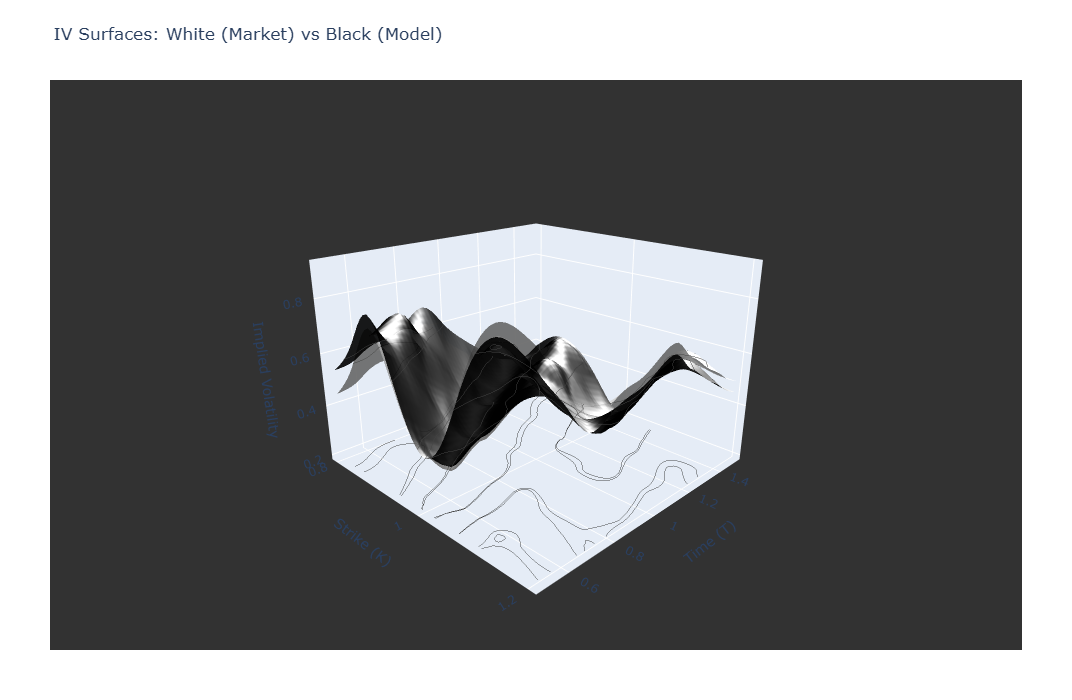

In [66]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata
def prepare_surface(df):
    K_grid = np.linspace(df['K'].min(), df['K'].max(), 50)
    T_grid = np.linspace(df['T'].min(), df['T'].max(), 50)
    K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)
    iv_mesh = griddata(
        (df['K'], df['T']), df['iv'],
        (K_mesh, T_mesh), method='cubic'
    )
    return K_mesh, T_mesh, iv_mesh
K1, T1, iv1 = prepare_surface(df_filtered)
K2, T2, iv2 = prepare_surface(option_grid)
white_scale = [[0, 'white'], [1, 'white']]
black_scale = [[0, 'black'], [1, 'black']]
fig = go.Figure()
fig.add_trace(go.Surface(
    x=K1, y=T1, z=iv1,
    surfacecolor=np.ones_like(iv1), 
    colorscale=white_scale,
    name='Market IV',
    opacity=0.9,
    showscale=False, 
    lighting=dict(
        ambient=0.4,
        diffuse=0.6,
        fresnel=0.2,
        specular=0.8
    )
))
fig.add_trace(go.Surface(
    x=K2, y=T2, z=iv2,
    surfacecolor=np.ones_like(iv2), 
    colorscale=black_scale,
    name='Model IV',
    opacity=0.9,
    showscale=False,  
    lighting=dict(
        ambient=0.1,
        diffuse=0.9,
        fresnel=0.1,
        specular=1.0
    )
))
fig.update_layout(
    title='IV Surfaces: White (Market) vs Black (Model)',
    scene=dict(
        xaxis_title='Strike (K)',
        yaxis_title='Time (T)',
        zaxis_title='Implied Volatility',
        bgcolor='rgb(50,50,50)',
        camera=dict(eye=dict(x=1.5, y=-1.5, z=0.8)),
        aspectratio=dict(x=1, y=1, z=0.7)
    ),
    width=1000,
    height=700,
    margin=dict(l=50, r=50, b=50, t=80),
    legend=dict(
        x=0.7,
        y=0.9,
        font=dict(color='white'),
        bgcolor='rgba(0,0,0,0.5)'
    )
)

fig.update_traces(
    contours_z=dict(
        show=True,
        usecolormap=False,
        highlightcolor="limegreen",
        project_z=True
    )
)

fig.show()

In [67]:
np.sqrt(np.sum((df_filtered['iv']-option_grid['iv'])**2)/option_grid.shape[0])

0.03449441511221283

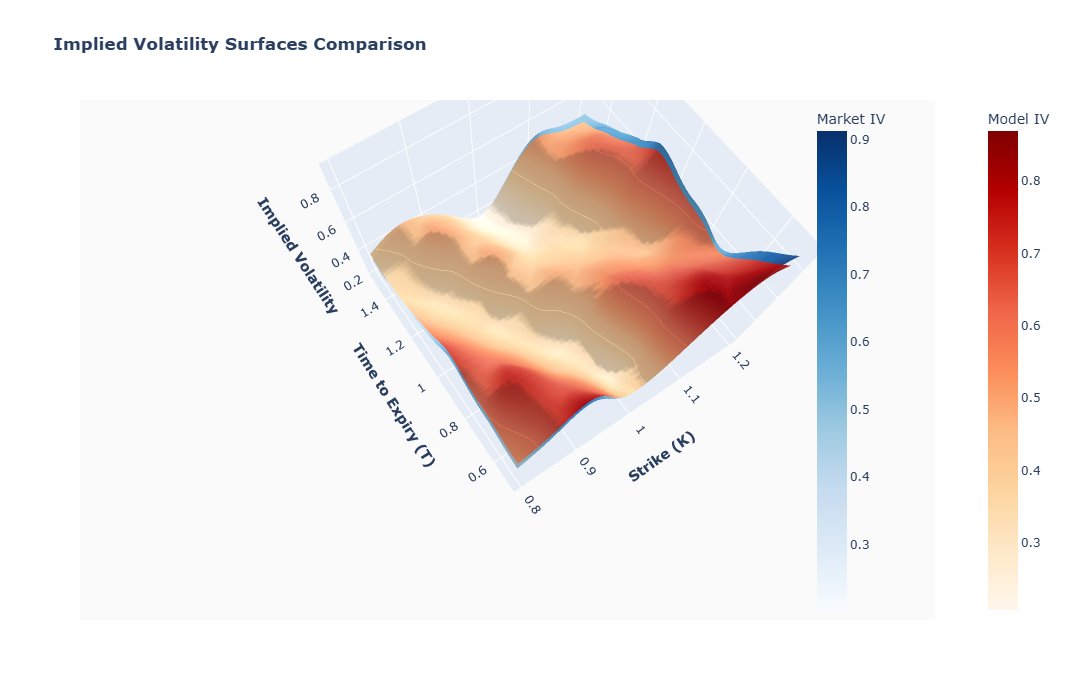

In [138]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata
K1, T1, iv1 = prepare_surface(df_filtered)
K2, T2, iv2 = prepare_surface(option_grid)
fig = go.Figure()
fig.add_trace(go.Surface(
    x=K1, y=T1, z=iv1,
    colorscale='Blues',
    name='<b>Market IV</b>',
    opacity=0.9,
    showscale=True,
    contours_z=dict(show=True, usecolormap=True),
    colorbar=dict(title='Market IV', x=0.85)
))т
fig.add_trace(go.Surface(
    x=K2, y=T2, z=iv2,
    colorscale='OrRd',
    name='<b>Model IV</b>',
    opacity=0.9,
    showscale=True,
    contours_z=dict(show=True, usecolormap=True),
    colorbar=dict(title='Model IV', x=1.05)
))
fig.update_layout(
    title='<b>Implied Volatility Surfaces Comparison</b>',
    scene=dict(
        xaxis_title='<b>Strike (K)</b>',
        yaxis_title='<b>Time to Expiry (T)</b>',
        zaxis_title='<b>Implied Volatility</b>',
        bgcolor='rgb(250,250,250)',  
        camera=dict(eye=dict(x=-1.5, y=-1.5, z=0.8)),  
        aspectratio=dict(x=1, y=1, z=0.7) 
    ),
    width=1100,
    height=700,
    margin=dict(l=80, r=80, b=80, t=100),
    legend=dict(
        x=0.7,
        y=0.9,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black'
    )
)

fig.update_traces(
    contours_z=dict(show=True, width=5),
    selector=dict(type='surface')
)

fig.show()